# Project description

We work for OilyGiant mining company. Our task is to find the best place for a new well by using data on oil samples from three regions. Parameters of each oil well in the region are already known. We need to build a model that will help to pick the region with the highest profit margin and then analyze potential profit and risks using the Bootstrapping technique.

**Steps to choose location:**
- Collect oil well parameters in the selected region: oil quality and volume of reserves.
- Build a model for predicting the volume of reserves in the new wells.
- Pick oil wells with highest estimated values.
- Pick region with highest total profit for the selected oil wells.

# Data description

**Columns:**
- `id` — unique oil well identifier
- `f0`, `f1`, `f2` — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- `product` — volume of reserves in the oil well (thousand barrels).

**Conditions:**
- Only linear regression is suitable for model training (rest are not sufficiently predictable).
- When exploring region, a study of 500 points is carried with picking best 200 points for profit calculation.
- Budget for development of 200 oil wells is 100 million USD.
- One barrel of raw materials brings 4.5 USD of revenue. Revenue from one unit of product is 4,500 USD (volume of reserves is in thousand barrels).
- After risk evaluation, only regions with the risk of losses lower than 2.5% are kept and from those that fit criteria, region with highest average profit is selected.

The data is synthetic: contract details and well characteristics are not disclosed.

# Library imports

In [1]:
#Libraries and project environment setup:

##Pandas, Numpy, Re and Datetime for data preprocessing and manipulation
import pandas as pd
import numpy as np

##Remove warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

##Scipy for SDA
from scipy import stats as st

##Matplotlib and Seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#SKLearn for ML
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss

# CSV file read

In [2]:
#We use try-except to handle unexpected errors
try:
    df0 = pd.read_csv('/Downloads/geo_data_0.csv')
    df1 = pd.read_csv('/Downloads/geo_data_1.csv')
    df2 = pd.read_csv('/Downloads/geo_data_2.csv')

except:
    df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

# General info

## Geo data 0

In [3]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df0.drop_duplicates(inplace=True, keep='last')
df0.reset_index(drop=True, inplace=True)

#Print the first five entries in the dataframe
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


No NaN values.

In [4]:
#General file examination (missing values and data types)
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 100000 entries and 5 columns.
- No missing values.
- Data types seem fine.

In [5]:
#Integrated display of the columns
df0.describe(include='all')

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,A5aEY,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


- `f0`, `f1`, `f2` features in all 3 dataframes seem to be normally distributed with close mean and median values.
- Target variable is continuous, so we will need to use a regression model for predictions. The target's distribution also seems normal.

## Geo data 1

In [6]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df1.drop_duplicates(inplace=True, keep='last')
df1.reset_index(drop=True, inplace=True)

#Print the first five entries in the dataframe
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


No NaN values.

In [7]:
#General file examination (missing values and data types)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 100000 entries and 5 columns.
- No missing values.
- Data types seem fine.

In [8]:
#Integrated display of the columns
df1.describe(include='all')

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,LHZR0,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


- `f0`, `f1`, `f2` features in all 3 dataframes seem to be normally distributed with close mean and median values.
- Target variable is continuous, so we will need to use a regression model for predictions. The target's distribution also seems normal.

## Geo data 2

In [9]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df2.drop_duplicates(inplace=True,keep='last')
df2.reset_index(drop=True, inplace=True)

#Print the first five entries in the dataframe
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


No NaN values.

In [10]:
#General file examination (missing values and data types)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 100000 entries and 5 columns.
- No missing values.
- Data types seem fine.

In [11]:
#Integrated display of the columns
df2.describe(include='all')

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,KUPhW,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


- `f0`, `f1`, `f2` features in all 3 dataframes seem to be normally distributed with close mean and median values.
- Target variable is continuous, so we will need to use a regression model for predictions. The target's distribution also seems normal.

# Model 

In [12]:
#Defining and running function to split data into train and valid sets at 75:25 ratio (X-features, y-target), train and predict
def modeling(df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

    sc = ss()
    X_train_scaled = sc.fit_transform(X_train)
    X_valid_scaled = sc.transform(X_valid)
    X_train = pd.DataFrame(data=X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_valid = pd.DataFrame(data=X_valid_scaled, index=X_valid.index, columns=X_valid.columns)

    base = DummyRegressor(strategy='mean')
    base.fit(X_train, y_train)
    y_pred = base.predict(X_valid)
    rmse_baseline = round(mean_squared_error(y_valid, y_pred)**0.5, 2)

    model = LinearRegression()
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    mse = mean_squared_error(y_valid, predicted_valid)
    rmse = round(mse**0.5, 2)
    predicted_valid_mean = round(predicted_valid.mean(), 2)

    return model, X_valid, y_valid, rmse_baseline, rmse, predicted_valid_mean


model0, X_v0, y_v0, rmse_bl0, rmse0, pred_v_mean0 = modeling(df0)
model1, X_v1, y_v1, rmse_bl1, rmse1, pred_v_mean1 = modeling(df1)
model2, X_v2, y_v2, rmse_bl2, rmse2, pred_v_mean2 = modeling(df2)

In [13]:
#Calculating and printing average volume of predicted reserves and RMSE
models = pd.DataFrame({
    'region': ['0', '1', '2'],
    'baseline': [rmse_bl0, rmse_bl1, rmse_bl2],
    'rmse': [rmse0, rmse1, rmse2],
    'avg. volume': [
        round(df0['product'].mean(), 2),
        round(df1['product'].mean(), 2),
        round(df2['product'].mean(), 2)],
    'predicted avg. volume': [pred_v_mean0, pred_v_mean1, pred_v_mean2]})

models['error %'] = round(models['rmse'] / models['predicted avg. volume'], 2) * 100

models = models.set_index('region')

models

,baseline,rmse,avg. volume,predicted avg. volume,error %
region,,,,,
0,44.29,37.58,92.50,92.59,41.0
1,46.02,0.89,68.83,68.73,1.0
2,44.90,40.03,95.00,94.97,42.0


All 3 models' RMSE is lower than the baseline, therefore models are slightly better than average estimate, with the exception of Region1 which also has a lower reserves' average predicted volume than others. 

We calculated percentage of model `error %` compared to average reserves' predicted volume. Error is over 40% in regions 0 and 2 yet only 1% in region 1.

Actual and predicted reserves' volumes are similar in all 3 regions.

# Profit

## Preparation

In [14]:
#Storing key values
N=500 #Number of points used in study
COUNT = 200  #Best points out of 500
BUDGET = 100000000  #USD for 200 wells
BARREL_REVENUE = 4.5  #USD per barrel
PRODUCT_REVENUE = 4500  #USD per product
RESERVES = 1000  #Barrels

#Calculating sufficient reserve volume to develop new well without losses
min_volume = round(BUDGET / (PRODUCT_REVENUE * COUNT), 2)

#Comparing obtained value with average reserve volume per region by adding min volume to existing models datarame
models['sufficient reserve volume'] = [min_volume, min_volume, min_volume]

models

,baseline,rmse,avg. volume,predicted avg. volume,error %,sufficient reserve volume
region,,,,,,
0,44.29,37.58,92.50,92.59,41.0,111.11
1,46.02,0.89,68.83,68.73,1.0,111.11
2,44.90,40.03,95.00,94.97,42.0,111.11


Min reserves' volume per well in new region must be at least 111.11K barrels in order to break even. All 3 regions' average reserves' predicted volume is lower. 

On avg. 200 random wells per region would result in a loss. To profit, we'll select most profitable wells per region to see if total reserves cover development cost.

## Function

In [15]:
#Creating datarames for actual target values and predictions
val0 = pd.DataFrame()
val0['pred'] = model0.predict(X_v0)
val0['actual'] = y_v0.values

val1 = pd.DataFrame()
val1['pred'] = model1.predict(X_v1)
val1['actual'] = y_v1.values

val2 = pd.DataFrame()
val2['pred'] = model2.predict(X_v2)
val2['actual'] = y_v2.values


#Defining function to calculate profit per region
def profit(target, pred):
    target = pd.Series(target).reset_index(drop=True)
    pred_sorted = pd.Series(pred).sort_values(ascending=False)
    selected = target[pred_sorted.index][:COUNT]
    return (((selected.sum() * (BARREL_REVENUE * RESERVES)) - BUDGET) / 1000000)

#Running function
profit0 = profit(val0['actual'], val0['pred'])
profit1 = profit(val1['actual'], val1['pred'])
profit2 = profit(val2['actual'], val2['pred'])

#Creating and displaying dataframe
profit_df = (pd.DataFrame([profit0, profit1, profit2], columns=['Profit']))
profit_df = profit_df.reset_index()
profit_df.columns = ['Region', 'Profit in USD millions']
profit_df = profit_df.set_index('Region')
display(profit_df)

,Profit in USD millions
Region,
0,33.208260
1,24.150867
2,27.103500


Region0 has highest predicted profit of 33,208,260 USD thus is best for development.

In [16]:
#Defining function to find wells with highest predictions per region
def top(target, pred):
    target = pd.Series(target).reset_index(drop=True)
    pred_sorted = pd.Series(pred).sort_values(ascending=False)
    selected = target[pred_sorted.index][:COUNT]
    return selected.head(1)


#Running function
print('Region 0 top well:',
      top(val0['actual'], val0['pred']).to_string(), '\n')
print('Region 1 top well:',
      top(val1['actual'], val1['pred']).to_string(), '\n')
print('Region 2 top well:', top(val2['actual'], val2['pred']).to_string())

Region 0 top well: 9317    162.810993 

Region 1 top well: 20430    137.945408 

Region 2 top well: 22636    175.103291


Region2 has the most profitable well.

## Bootstrapping

Practically the company chooses 500 random wells, measures features' values (`f0`, `f1`, `f2`) and selects the best 200 wells for profit calculation.

We'll use `np.random.RandomState()` for each new call's state to be randomized, resulting in different subsamples.

Given same element should fall into a subsample several times, we'll use `replace=True` in `sample()` function.

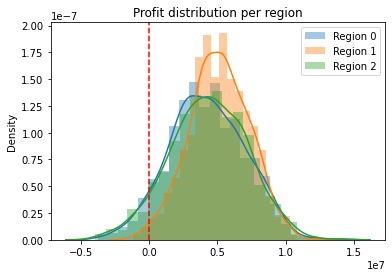

In [17]:
#Defining bootstrapping function to find profit distribution
def bs_profit(target, pred):
    pred_sorted = pred.sort_values(ascending=False)
    target = target[pred_sorted.index][:COUNT]
    return (((target.sum() * (BARREL_REVENUE * RESERVES)) - BUDGET))


def bs(target, pred):
    state = np.random.RandomState(12345)
    profit = []
    for i in range(1000):
        target_subsample = target.sample(n=N, replace=True, random_state=state)
        pred_subsample = pred[target_subsample.index]
        profit.append(bs_profit(target_subsample, pred_subsample))
    return pd.Series(profit)


#Running function
bs0 = bs(val0['actual'], val0['pred'])
bs1 = bs(val1['actual'], val1['pred'])
bs2 = bs(val2['actual'], val2['pred'])

#Plotting
sns.distplot(bs0, label='Region 0')
sns.distplot(bs1, label='Region 1')
sns.distplot(bs2, label='Region 2')
plt.axvline(0, c="r", ls='--')
plt.title('Profit distribution per region')
plt.legend();

Histograms above depict it's unlikely for developers to lose. Bootstrapping with 1000 samples provides confidence given normal distributions.

Biggest profit range part of all 3 regions is above the break-even point.

Region1 has highest profit distribution and contains mostly positive values.
Thus we suggest Region1 is selected for oil wells' development. 

Now, we'll conduct risk assessment to validate this.

## Loss risk, profit and 95% confidence interval

Company requires loss risk lower than 2.5% for new regions.

In [18]:
#Defining function to find confidence interval, avg. profit loss risk per region
def CI(profit):
    ci = st.t.interval(0.95, len(profit)-1, profit.mean(), profit.sem())
    risk = (profit < 0).mean()
    print('Avg. region profit:',profit.mean())
    print('95% confidence interval:', ci[0], ',' ,ci[1] )
    print('Loss risk {:.2%}'.format(risk))
    lower = profit.quantile(0.025)
    upper = profit.quantile(0.975)
    print('Quantile method confidence interval:', lower, ',',upper)

In [19]:
#Running function
CI(bs0)

Avg. region profit: 4259385.269105929
95% confidence interval: 4087322.0706869913 , 4431448.467524867
Loss risk 6.00%
Quantile method confidence interval: -1020900.9483793724 , 9479763.533583675


In [20]:
CI(bs1)

Avg. region profit: 5152227.734432902
95% confidence interval: 5016214.761763221 , 5288240.707102584
Loss risk 1.00%
Quantile method confidence interval: 688732.2537050088 , 9315475.912570495


In [21]:
CI(bs2)

Avg. region profit: 4350083.627827559
95% confidence interval: 4174535.520413581 , 4525631.735241537
Loss risk 6.40%
Quantile method confidence interval: -1288805.473297878 , 9697069.541802654


Region 1 has highest avg. profit and lowest loss risk.

# Conclusion

We work for OilyGiant mining company. 

In this project our task was to find the best place for a new well by using data on oil samples from three regions. To accomplish this we built a  LinearRegression model to help pick the region with the highest profit margin and potential profit, and risks using bootstrapping technique.

Results revealed the following: 
Region 1 has highest avg. profit 5152227.73 and lowest loss risk 1% and therefore we recommend to develop there.